## Deep Dream

Codificação adaptada da documentação do TensorFlow: https://www.tensorflow.org/beta/tutorials/generative/deepdream
 
- O objetivo do algoritmo é selecionar uma camada para maximizar a loss function, que são as ativações
- Podemos selecionar qualquer camada, lembrando que as primeiras camadas possuem características mais simples (bordas) e camadas superiores possuem características mais complexas e detalhadas dos objetos

**Importação das bibliotecas**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

**Importação do modelo com pesos pré-treinados**

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 6s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [ ]:
# names = ['mixed8', 'mixed9']
#names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']
names = ['mixed3', 'mixed5']
# names = ['mixed5']

In [ ]:
layers = [base_model.get_layer(name).output for name in names]

In [ ]:
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [ ]:
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

**Processar uma imagem**

In [ ]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/StaryNight.jpg',
                                                     target_size = (225, 375))

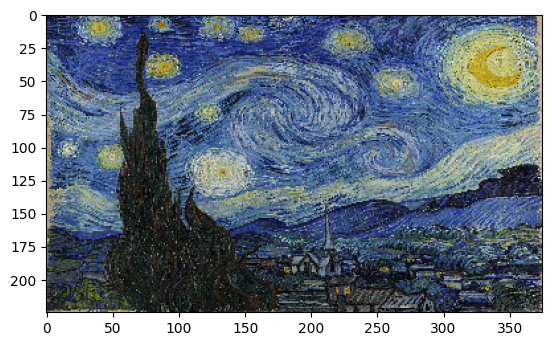

In [ ]:
plt.imshow(sample_image)

In [ ]:
type(sample_image)

PIL.Image.Image

In [ ]:
sample_image = np.array(sample_image) / 255
#or sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image.shape

(225, 375, 3)

In [ ]:
type(sample_image)

numpy.ndarray

In [ ]:
sample_image.max()

1.0

In [ ]:
sample_image.min()

0.0

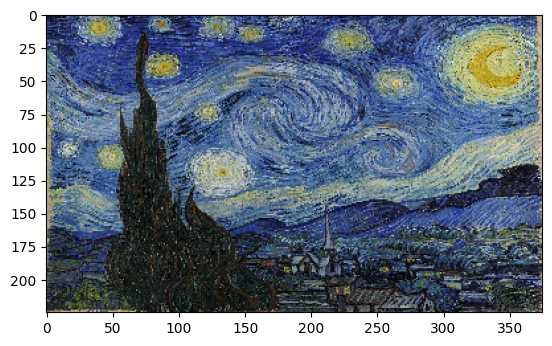

In [ ]:
plt.imshow(sample_image)

**Executar o modelo pré-treinado e explorar as ativações**

In [ ]:
sample_image = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_image))

In [ ]:
type(sample_image)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [ ]:
sample_image = tf.expand_dims(sample_image, axis = 0)

In [ ]:
sample_image.shape

TensorShape([1, 225, 375, 3])

In [ ]:
activations = deepdream_model(sample_image)

In [ ]:
len(activations)

2

In [ ]:
activations[1]

<tf.Tensor: shape=(1, 12, 21, 768), dtype=float32, numpy=
array([[[[3.3623042 , 4.190621  , 3.9559455 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 3.2915688 , ..., 0.        ,
          0.        , 0.        ],
         [1.1932659 , 2.8545113 , 0.9676059 , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.04281077, 1.3122519 , 1.0145401 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 2.0416925 , ..., 0.        ,
          0.        , 0.04361783],
         [1.5414286 , 1.8796768 , 1.8178902 , ..., 0.        ,
          0.        , 0.19873485]],

        [[1.1934956 , 2.1502755 , 2.3389976 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 4.645838  , ..., 0.        ,
          0.        , 0.        ],
         [0.21733567, 1.6891714 , 0.23644142, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.452391

**Cálculo da loss**

- Na maioria das vezes o objetivo é minizar o erro (loss) usando a descida gradiente, porém, em deep dream o objetivo é maximizar a loss (gradient ascent) 

In [ ]:
def calc_loss(image, model, test = 1):
  if test == 1:
    img_batch = tf.expand_dims(image, axis = 0)
    layer_activations = model(img_batch)
  else:
    layer_activations = model(image)
    
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
  
  print('Losses from multiple activation layers = ', losses)
  print('Losses shape = ', tf.shape(losses))
  print('Sum of all losses = ', tf.reduce_sum(losses))

  return tf.reduce_sum(losses)

In [ ]:
loss = calc_loss(sample_image, deepdream_model, test = 0)
loss

Losses from multiple activation layers =  [<tf.Tensor: shape=(), dtype=float32, numpy=0.2634555>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17727216>]
Losses shape =  tf.Tensor([2], shape=(1,), dtype=int32)
Sum of all losses =  tf.Tensor(0.44072765, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.44072765>

**Subida do gradiente**

In [ ]:
@tf.function
def deepdream(model, image, step_size):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = calc_loss(image, model)

  gradients = tape.gradient(loss, image)
  gradients /= tf.math.reduce_std(gradients)
  image = image + gradients * step_size
  image = tf.clip_by_value(image, -1, 1)

  return loss, image

In [ ]:
def run_deep_dream_simple(model, image, steps = 100, step_size = 0.01):
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  for step in range(steps):
    loss, image = deepdream(model, image, step_size)

    if step % 100 == 0:
      plt.figure(figsize = (12, 12))
      plt.imshow(deprocess(image))
      plt.show()
      print('Step {}, loss {}'.format(step, loss))

  plt.figure(figsize = (12, 12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image)

In [ ]:
def deprocess(image):
  image = 255 * (image + 1.0) / 2.0
  return tf.cast(image, tf.uint8)

**Primeiro teste**

In [ ]:
test_image = tf.keras.preprocessing.image.load_img(r'/content/StaryNight.jpg',
                                                     target_size = (225, 375))
test_image = np.array(test_image)
#test_image = tf.keras.applications.inception_v3.preprocess_input(test_image)

In [ ]:
np.shape(test_image)

(225, 375, 3)

In [ ]:
type(test_image)

numpy.ndarray

In [ ]:
dream_img = run_deep_dream_simple(model = deepdream_model, image = test_image,
                                  steps = 2000, step_size = 0.001)

**Executando em mais dimensões**

In [ ]:
escala = 1.3
test_image2 = tf.keras.preprocessing.image.load_img(r'/content/sky.jpeg',
                                                     target_size = (225, 375))
#test_image2 = np.array(test_image2)
#test_image2 = tf.keras.applications.inception_v3.preprocess_input(test_image2)

image = tf.constant(np.array(test_image2))
base_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

In [ ]:
type(image)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
np.shape(image)

TensorShape([225, 375, 3])

In [ ]:
type(base_shape)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
np.shape(base_shape)

TensorShape([2])

In [ ]:
for n in range(5):
  new_shape = tf.cast(base_shape * (escala**n), tf.int32)
  image = tf.image.resize(image, new_shape).numpy()
  image = run_deep_dream_simple(model=deepdream_model,image = image,
                                steps = 400, step_size = 0.001)